### Setup

In [1]:
# connect to google drive
import os
import numpy as np

# mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# change root directory such that models are saved in google drive during training
root_dir = "/content/gdrive/My Drive/DeepFLY"
os.chdir(root_dir)
# print the contents
!ls

all_attractions.pkl	  LP_Scrape.ipynb		   scripts
all_reviews.pkl		  Modelling.ipynb		   TA_scrape.ipynb
apify_data		  Modelling_refactored.ipynb	   text_data
EDA.ipynb		  notebook2script.py		   triposo_data
Feature_extraction.ipynb  poi_database.json		   Triposo_Scrape.ipynb
features		  scrape_data_with_apify.ipynb
image_data		  scrape_triposo_refactored.ipynb


### Imports

In [0]:
# export
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import sleep
import sys
import re
import shutil
import json
from tqdm import tqdm_notebook
import operator
from collections import OrderedDict
import pickle
import itertools
import gc
import spacy
nlp = spacy.load('en_core_web_sm')
import matplotlib.cm as cm

In [0]:
%matplotlib inline

In [0]:
# export
# insert the path for utility custom functions
import sys
sys.path.insert(0, os.path.join(root_dir, 'scripts'))

# custom python functions and classes
from nb_scrape_triposo import create_df, poi_counts

In [0]:
# Export
# clustering
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS # need to install
from sklearn.manifold import TSNE

# sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, decomposition
from sklearn.metrics.pairwise import linear_kernel

### Load data

#### Apify data

In [0]:
all_reviews = pd.read_pickle('all_reviews.pkl')
all_att = pd.read_pickle('all_attractions.pkl')

In [6]:
print("{} Attractions extracted from Trip Advisor".format(len(all_att)))
print("{} reviews extracted from Trip Advisor".format(len(all_reviews)))

109333 Attractions extracted from Trip Advisor
2549347 reviews extracted from Trip Advisor


#### Triposo data

In [7]:
## Read the dataset
with open('poi_database.json','r') as f:
  dataset = json.load(f)
##
countries = list(dataset.keys())
print("{} Countries in dataset".format(len(countries)))
print("Last extracted {}".format(countries[-1]))

130 Countries in dataset
Last extracted Nebraska


In [0]:
poi_df = create_df(dataset)

In [13]:
print('{} POIs extracted from Triposo'.format(len(poi_df)))

230755 POIs extracted from Triposo


### EDA - Trip Advisor (TA)

#### Attractions EDA

In [0]:
# export
## Additional features
def split_try(x):
  try:
    y = x.split(',')
  except:
    return ['default']
  return y
###
def composite_cat(x):
  L = []
  for macro in x[0]:
    for micro in x[1]:
      L.append('_'.join([macro, micro]))
  return L
####

In [0]:
## Define meta categories using category_names and subtype_names
all_att['macro_cats'] = all_att['category_names'].apply(lambda x: x.split(','))
all_att['micro_cats'] = all_att['subtype_names'].apply(lambda x:split_try(x))
all_att = all_att.drop(columns = ['category_names','subtype_names'], axis = 1)
all_att['meta'] = all_att[['macro_cats','micro_cats']].apply(composite_cat, axis = 1)

In [16]:
## Find all meta classes
meta_list = list(itertools.chain.from_iterable(all_att['meta'].values))
print('total number of attractions type: {}'.format(len(set(meta_list))))

total number of attractions type: 1745


In [0]:
## Number of attractions under each meta category
meta_freq = {}

for i in range(len(all_att)):
  i_meta = all_att.iloc[i].meta
  for item in i_meta:
    if item in meta_freq.keys():
      meta_freq[item] += 1
    else:
      meta_freq[item] = 1
  

In [19]:
## Meta categories having more than cutoff number of observations
cut_off = 50
meta_keep = []
for k,v in meta_freq.items():
  if v >= cut_off:
    meta_keep.append(k)
##
print("retained meta categories = {} with cutoff = {}".format(len(meta_keep), cut_off))

retained meta categories = 591 with cutoff = 50


In [20]:
## Example of a meta category
idx = 253
key = meta_keep[idx]
print('Number of attractions in category: {} = {}'.format(key,meta_freq[key]))

Number of attractions in category: Outdoor Activities_Parasailing & Paragliding = 183


#### EDA Reviews

In [21]:
### Number of users with more than eq to N reviews
## Group reviews by user
review_grps = all_reviews.groupby('user')
users_list = []
### Make a list of users with more than n reniews
n = 4
for name, grp in review_grps:
  if(grp['location_id'].nunique()>=n):
    users_list.append(name)
##
print('Number of users with more than {} reviews = {}'.format(n,len(users_list)))

Number of users with more than 4 reviews = 53496


In [22]:
## Check reviews by a particular user
idx = 4346
uname = users_list[idx]
un_commnets = review_grps.get_group(uname)
un_commnets = un_commnets.drop_duplicates(subset='location_id')
print('{} has commented {} times'.format(uname, un_commnets['location_id'].nunique()))
un_commnets.sample(min(len(un_commnets), 30))

Andreaschandra86 has commented 19 times


,comment,location_id,location_name,rating,title,user
90432,Kedung Pedut is Waterfall that located inside ...,10784981,Kedung Pedut Waterfall,5,The Hidden Waterfall in Menoreh hills,Andreaschandra86
93949,"we starting at 4 am from Yogyakarta , it was t...",9758563,Borobudur Sunrise,5,golden sunrise from the top 7 wonders of world...,Andreaschandra86
89822,we can entered this place from Menoreh Hills o...,7312838,Kalibiru National Park,3,watched sermo lake from high place,Andreaschandra86
88205,This place well-known as Royal recreation park...,379334,Water Castle (Tamansari),3,"The royal recreation park , open for public",Andreaschandra86
100651,We reached this area through Ungaran ( alterna...,6692272,Kreo Cave,4,Cave in the middle of the lake,Andreaschandra86
87141,traditional dance perfomance combine with beau...,7055583,Ramayana Ballet at Prambanan,5,Amazing traditional Dance original in Yogyakarta,Andreaschandra86
89949,It was a symbol of jogjakarta which ones calle...,8685882,Yogyakarta Monument,5,Historical monuments,Andreaschandra86
89228,since last year malioboro street was reform in...,447268,Malioboro Road,5,new face of pedestrian of malioboro street,Andreaschandra86
91731,Glugut park built by people that live in those...,15059284,Glugut Park,3,Park inside the village built by villagers,Andreaschandra86
90903,"Sermo Lake located in Wates Region, this is a ...",5062610,Waduk Sermo,3,"Large lake for Irigation, Recreation,and conse...",Andreaschandra86


In [0]:
## Distributions with number of columns
list_num_comments =[]
for name in users_list:
  cmnt = review_grps.get_group(name)
  list_num_comments.append(cmnt['location_id'].nunique())

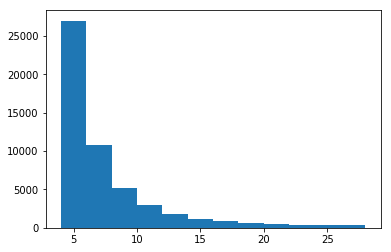

In [24]:
# Plot histogram
bins = np.arange(4,30,2)
plt.hist(np.array(list_num_comments),  bins=bins);

In [0]:
## Filter reviews: all distinct + for users who commented at least 5 times
list_user_reviews =[]
for name in users_list:
  cmnt = review_grps.get_group(name)
  cmnt = cmnt.drop_duplicates(subset='location_id')
  list_user_reviews.append(cmnt)

In [26]:
# create dataframe
clean_reviews = pd.concat(list_user_reviews, ignore_index = True)
print('Number of clean reviews = {}'.format(len(clean_reviews)))

Number of clean reviews = 436412


In [27]:
# examples of clean reviews
clean_reviews.sample(5)

,comment,location_id,location_name,rating,title,user
131294,This park is pretty artistic but to be honest ...,10364884,Garuda Park,4,SMALL WITH TWO BENCHES,JUDIS_UTAMA
346497,The place is very far indeed and I would stron...,654659,Annah Rais Longhouse Adventure,4,Need a guide to get there,fridaywoo
381878,Booked a private tour for a half day with a vi...,1798690,Thai Private Tour Guide,5,Perfect Tour!,marykZ1055RE
141638,My first Thai massage (Royal Thai Massage). Cl...,8654044,Dahra Beauty & Spa - Sukhumvit,5,Awesome experience!,Jerry H
271393,We booked our tour with Tong through email whe...,1580840,Tour with Tong,5,Amazing tour with Yuth!,Stephanie K


In [28]:
## Stats on clean reviews
clean_reviews['rating'] = clean_reviews['rating'].apply(lambda x: int(x))
clean_reviews['rating'].describe()

count    436412.000000
mean          4.370927
std           0.892578
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

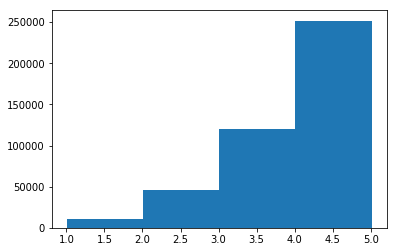

In [35]:
plt.hist(clean_reviews['rating'], bins = [1.01, 2.01,3.01,4.01,5.01]);

### EDA - Triposo

In [40]:
## A typical POI
dataset['India']['Darjeeling']['5']

{'info': "\nHappy Valley Tea Estate is a tea garden in Darjeeling district in the Indian state of West Bengal. Established in 1854, it is Darjeeling's second oldest tea estate. Spread over 177hectare, it is situated at a height of 2100m above sea level, 3km north of Darjeeling, and employs more than 1500 people.\n",
 'pic_url': 'pic.triposo.com/ios/cas/medium/ad86/ad8698ceb5d2960085d9578dd6762a8f058abfa530de3f8b89755095b889d363',
 'poi': 5,
 'poi_type': 'sight',
 'sub_url': 'https://www.triposo.com/poi/T__faf2f1cd506e',
 'title': 'Happy Valley Tea Estate'}

In [39]:
## POI type frequency
poi_freq = poi_counts(poi_df)
## Top POI types
poi_freq[0:15]

sight         46675
museum        38720
park          28234
church        19405
mountain       8556
memorial       8493
theatre        6235
bridge         5972
city hall      5286
castle         5235
library        5209
temple         3863
lake           3008
tower          2592
university     2533
dtype: int64

#### Basic cleaning

In [0]:
# export
## Remove \n from start and end
def remove_new_line(x):
  try:
    return x[1:-1]
  except:
    pass

## Length of info
def word_counter(x):
  try:
    return len(x.split(' '))
  except:
    return 0

In [43]:
## clean info column for pois 
poi_df['info_clean'] = poi_df['info'].apply(lambda x: remove_new_line(x))  
poi_df['word_count'] = poi_df['info'].apply(lambda x: word_counter(x))
poi_df = poi_df.drop(columns = ['info'], axis = 1)
# stats on word count
poi_df['word_count'].describe()

count    230755.000000
mean         43.775090
std          71.699537
min           0.000000
25%           8.000000
50%          12.000000
75%          53.000000
max        5778.000000
Name: word_count, dtype: float64

Word count per POI info distribution


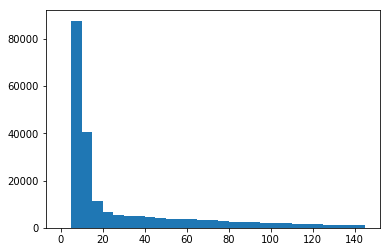

In [44]:
## word count histogram
print('Word count per POI info distribution')
bins = np.arange(0,150,5)
plt.hist(poi_df['word_count'], bins = bins);

#### Removing POIs with little info

In [45]:
### Drop POI with less than 6 in the word count
poi_df = poi_df[poi_df.word_count >= 6]
poi_df = poi_df.reset_index(drop=True)
print('Number of POIs after cleaning: {}'.format(len(poi_df)))

Number of POIs after cleaning: 230625


#### Clustering

In [0]:
## Use TF-iDF for extracting poi features
### Only 100 features are used for EDA
tf_op = TfidfVectorizer(analyzer = 'word', max_df = 0.95, min_df = 5, max_features = 500)
tfidf_matrix = tf_op.fit_transform(poi_df['info_clean'])

In [0]:
## POI features
X_poi = tfidf_matrix.todense()

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


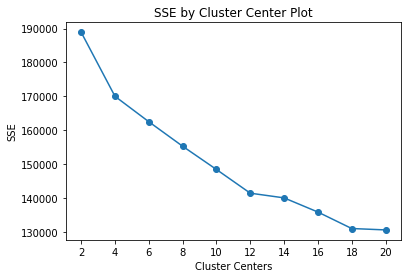

In [51]:
## Trying to use elbow method
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X_poi, 20)

In [0]:
# export
# n_clusters = 12 (elbow method)
clusters = MiniBatchKMeans(n_clusters=12, init_size=1024, batch_size=2048, random_state=20).fit_predict(X_poi)

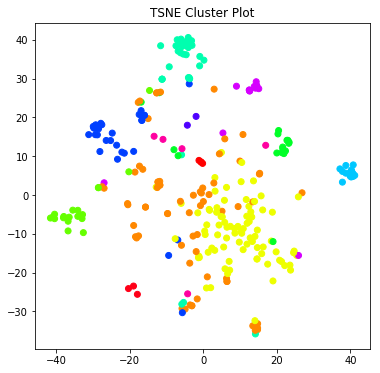

In [55]:
# export
# plot clusters
def plot_tsne_pca(data, labels):
    
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=1000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:])
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:]))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    # ax[0].set_title('PCA Cluster Plot')
    
    ax.scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax.set_title('TSNE Cluster Plot')
    
plot_tsne_pca(X_poi, clusters)

In [57]:
# export
# See top words in each cluster
df_clusters = pd.DataFrame(poi_df).groupby(clusters)
stop_words = ["monday"] + list(STOPWORDS)

for name, group in df_clusters:
  
  corpus = ' '.join(group['info_clean'])
  print('='*50)
  print('Cluster {}'.format(name))
  ## Plot
  df_wordcloud = WordCloud(stopwords = stop_words, background_color = 'white', height = 600, width = 800, max_words=100).generate(corpus)
  plt.figure(figsize = (16,8))
  plt.imshow(df_wordcloud)
  plt.axis('off')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
### Evidently cluster are bformed based on POI type

### Export

In [58]:
! pip install fire

In [59]:
!python notebook2script.py EDA.ipynb

Converted EDA.ipynb to nb_EDA.py


In [0]:
###### <<< ---- >>> ####